## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Use GPU

In [2]:
# torch.cuda.reset_peak_memory_stats()
# torch.cuda.empty_cache()

In [3]:
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
device = torch.device("cuda")
print(f"Using device: {"GPU" if torch.cuda.is_available() else "cpu"}")

PyTorch Version: 2.5.1+cu124
CUDA Version: 12.4
CUDA Available: True
Device Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using device: GPU


## Hyperparameters

In [29]:
input_dim = 784
hidden1_dim = 512
hidden2_dim = 256
latent_dim = 2
num_epochs = 100
learning_rate = 0.0001
batch_size = 1
sample_interval = 25
num_samples = 5
SEED = 13

In [5]:
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load & Ready Dataset (MNIST)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=False)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Loss Function

In [9]:
def loss_function_BCE(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [10]:
def loss_function_MSE(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

## VAE Model

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden1=512, hidden2=256, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU()
        )
        # Latent space parameters
        self.fc_mu = nn.Linear(hidden2, latent_dim)
        self.fc_logvar = nn.Linear(hidden2, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


## Main

In [12]:
losses = []

In [13]:
model = VAE(input_dim, hidden1_dim, hidden2_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
for param in model.parameters():
    param.data = param.data.to(torch.float32)
model = model.to(device)

## Train Model

In [24]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, _ in train_loader:
        images = images.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = loss_function_BCE(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # if (epoch + 1) % sample_interval == 0:
    #     model.eval()
    #     with torch.no_grad():
    #         sample_images = next(iter(test_loader))[0][:num_samples].to(device)
    #         sample_images_flat = sample_images.view(-1, 28*28)
    #         reconstructed, _, _ = model(sample_images_flat)

    #         fig_samples, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    #         for j in range(num_samples):
    #             axes[0, j].imshow(sample_images[j].cpu().squeeze(), cmap='gray')
    #             axes[0, j].set_title("Original")
    #             axes[0, j].axis('off')

    #             recon = reconstructed[j].cpu().view(28, 28)
    #             axes[1, j].imshow(recon, cmap='gray')
    #             axes[1, j].set_title("Reconstructed")
    #             axes[1, j].axis('off')
    #         plt.suptitle(f'Reconstructions at Epoch {epoch+1}')
    #         plt.tight_layout()
    #         plt.show()

Epoch [1/100], Loss: 137.0342
Epoch [2/100], Loss: 136.9670
Epoch [3/100], Loss: 136.9462


KeyboardInterrupt: 

## Evaluate Model

In [25]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        recon_images, mu, logvar = model(images)
        test_loss = loss_function_BCE(recon_images, images, mu, logvar).item()        
        break
        
print(f'\nTest Loss: {test_loss:.4f}')
print(f"\nTrain Loss: {losses[-1]:.4f}")


Test Loss: 93.4185

Train Loss: 136.9462


## Result

In [26]:
model = model.to(device)
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    sample_images = model.decoder(z).cpu().numpy().reshape(-1, 28, 28)

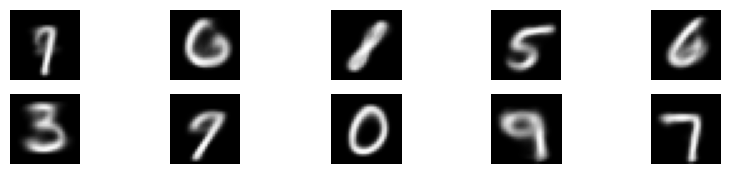

In [27]:
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.axis('off')
plt.show()

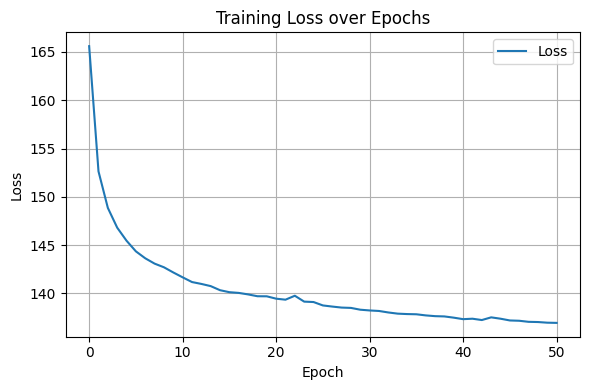

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()